In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window=20):
    """
    改进：引入流动性指标(turnover/trade_count)调整重心计算
    金融意义：在低流动性时段降低权重，避免市场操纵影响
    """
    df = df.copy()
    # 计算每根K线的流动性
    df['liquidity'] = df['turnover'] / df['trade_count']
    df['liq_rank'] = df.groupby(pd.Grouper(freq='D'))['liquidity'].transform(
        lambda x: x.rank(pct=True))
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # 流动性调整权重
        liq_weights = group['liq_rank'].values * 0.8 + 0.2  # 映射到0.2-1.0
        
        # 流动性调整上涨重心
        up_mask = group['close'] > group['open']
        if up_mask.any():
            up_weights = liq_weights[up_mask] * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        # 流动性调整下跌重心
        down_mask = group['close'] < group['open']
        if down_mask.any():
            down_weights = liq_weights[down_mask] * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d,
            'liquidity': group['liquidity'].mean()
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # 流动性感知回归
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna()
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        # 流动性作为回归特征
        X = train_data[['G_u', 'liquidity']].values
        y = train_data['G_d'].values
        model = LinearRegression().fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u'], current['liquidity']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 流动性调整因子值
    liq_adjust = 1 + (0.5 - daily_df['liquidity'].rank(pct=True))  # 低流动性放大信号
    daily_df['factor'] = daily_df['residual'].rolling(window).mean() * liq_adjust
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.009044
   Rank_IC (Spearman): 0.016246
📊 信息比率:
   IR: -0.078319
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127291
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


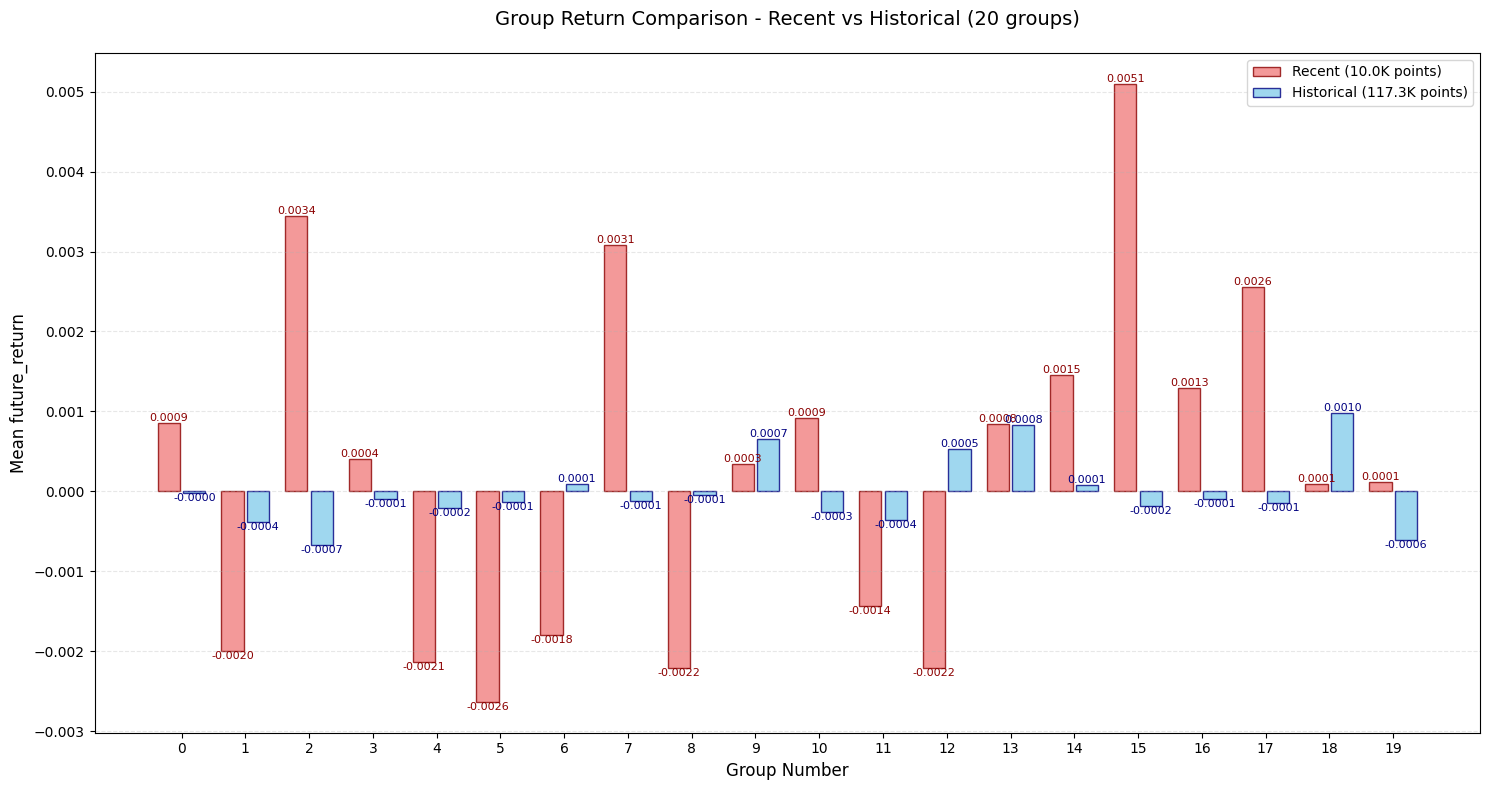

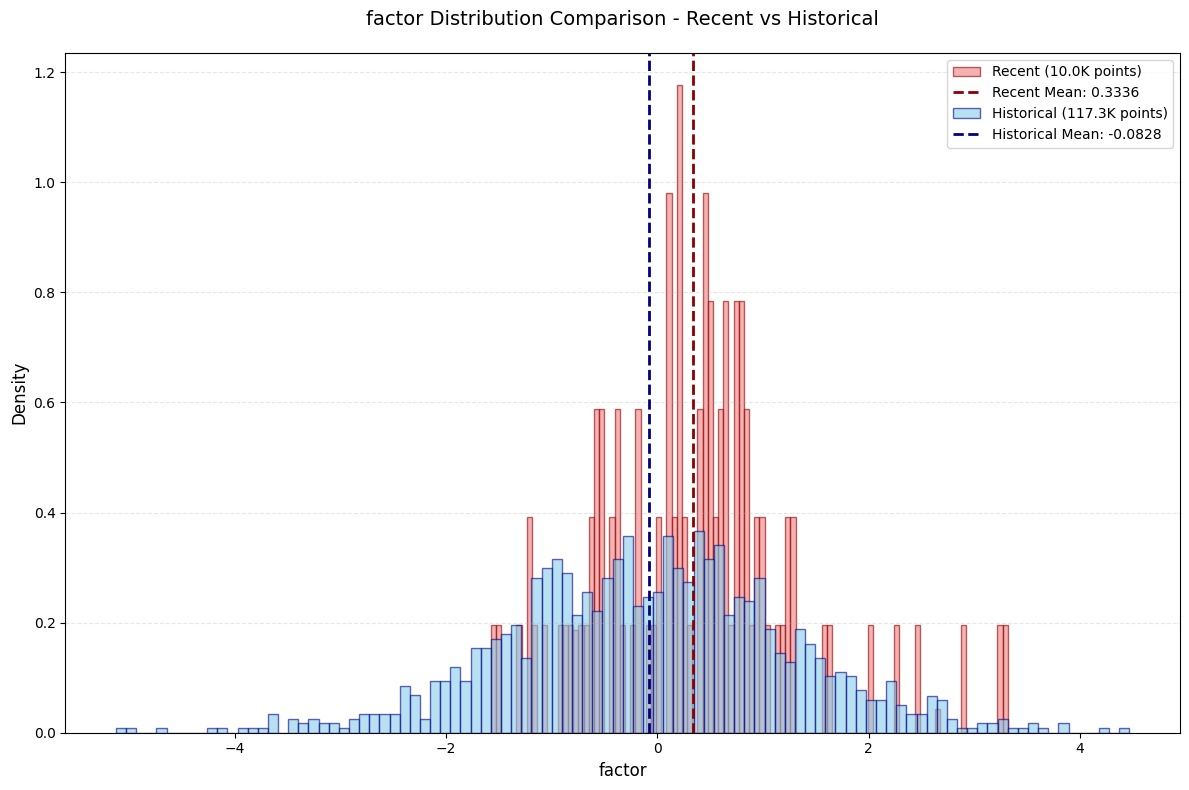

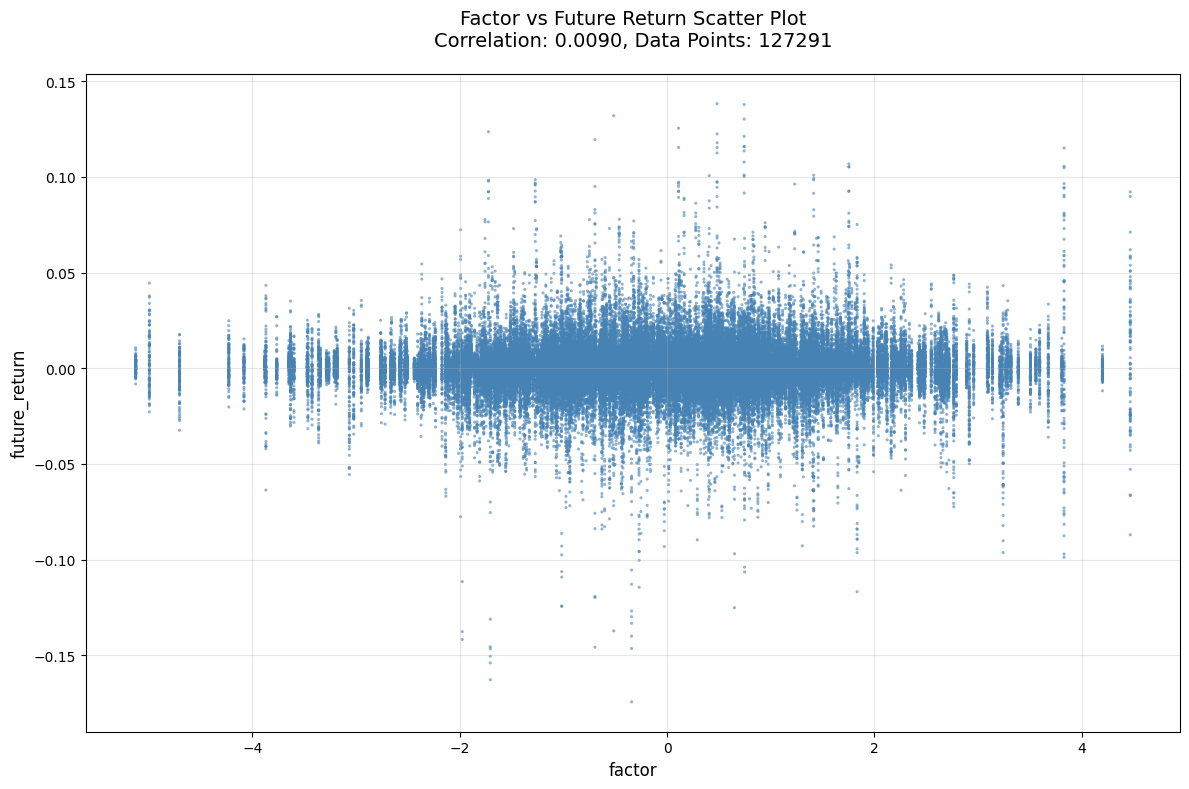

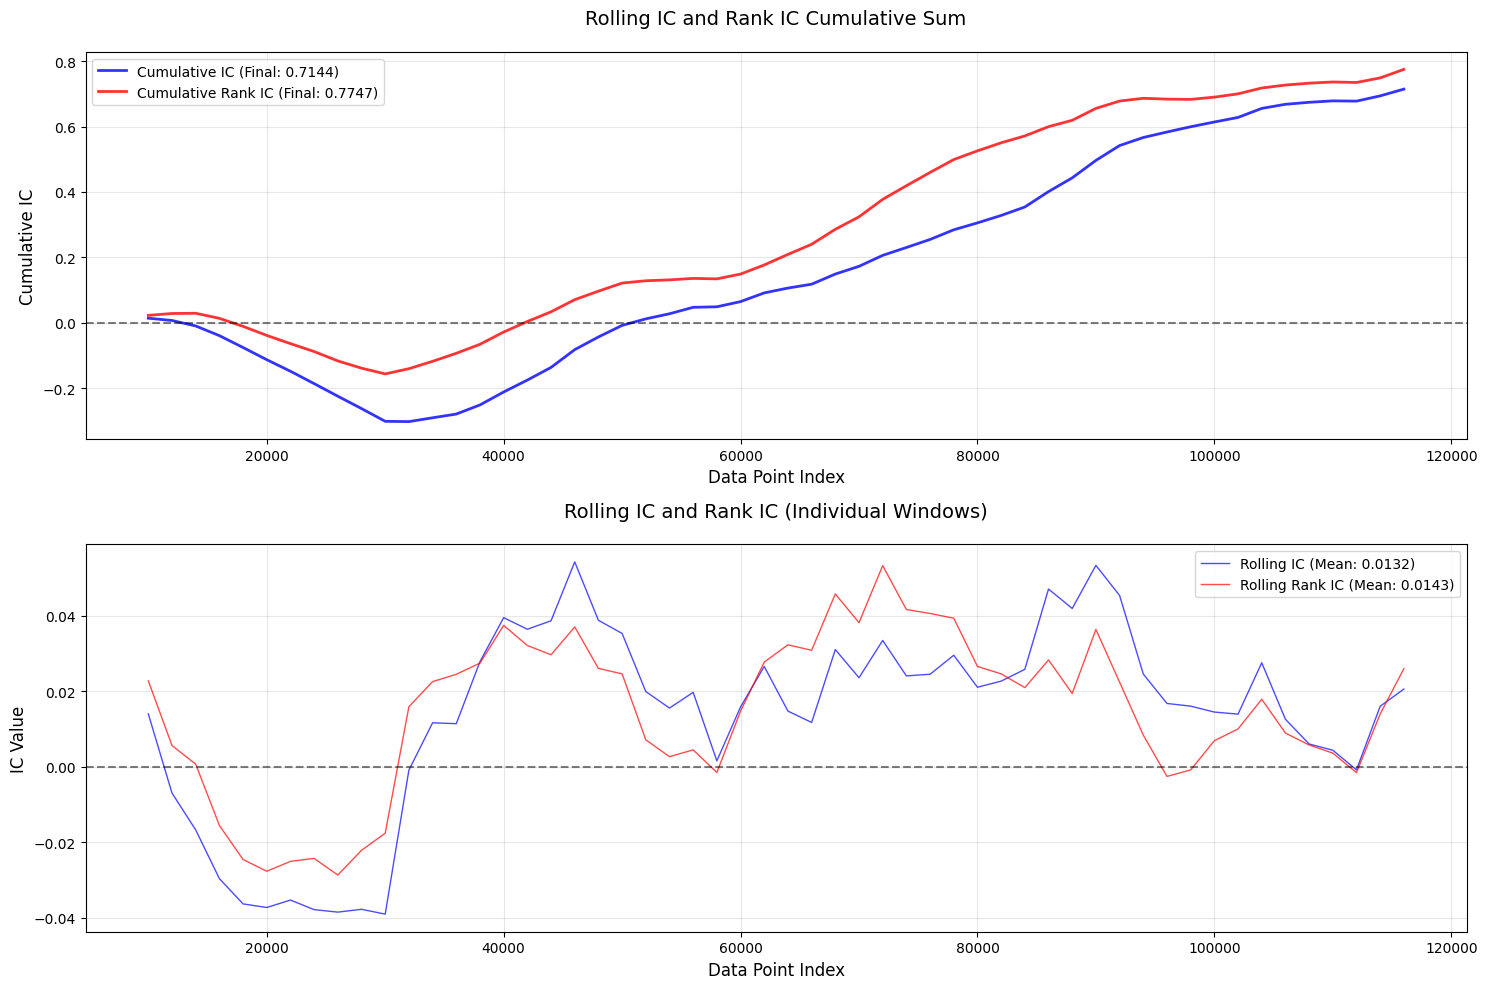

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.03805974890890431,
 0.006224744498244969,
 0.039726392917796505,
 -0.008552435839006504,
 0.031070481069211665,
 -0.0018752139135300068,
 -0.015984343245555598,
 0.010013495950913739,
 -0.004568143508491273,
 -0.03686991060722301]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.009044450066020584, 'Rank_IC': 0.016246288023653594}, 'information_ratio': {'IR': -0.07831942266843699, 'group_correlations': [-0.03805974890890431, 0.006224744498244969, 0.039726392917796505, -0.008552435839006504, 0.031070481069211665, -0.0018752139135300068, -0.015984343245555598, 0.010013495950913739, -0.004568143508491273, -0.03686991060722301], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -5.1260  -2.1339   -2.9126      -0.0000      0.0095   6432
1      -2.1247  -1.6593   -1.8739      -0.0008      0.0126   6336
2      -1.6579  -1.3635   -1.5046       0.0000      0.0108   6336
3      -1.3577  -1.1072   -1.2147      -0.0004      0.0104   6432
4      -1.1048  -0.9271   -1.0166      -0.0003      0.0120   6336
5      -0.9256  -0.7344   -0.8369       0.0005      0.0102   6331
6      -0.7340  -0.5302   -0.6257 